In [295]:
# Import required libraries
import numpy as np
import pandas as pd
from scipy.optimize import minimize
from datetime import datetime
import matplotlib.pyplot as plt
import yfinance as yf
from statsmodels.tsa.stattools import adfuller, kpss


In [296]:
# Set the start and end date for data
start_date = datetime(2023, 1, 1)
end_date = datetime(2024, 1, 31)
stock_symbol = 'NVDA'

# Download stock data
stock = yf.download(stock_symbol, start_date, end_date)

[*********************100%***********************]  1 of 1 completed


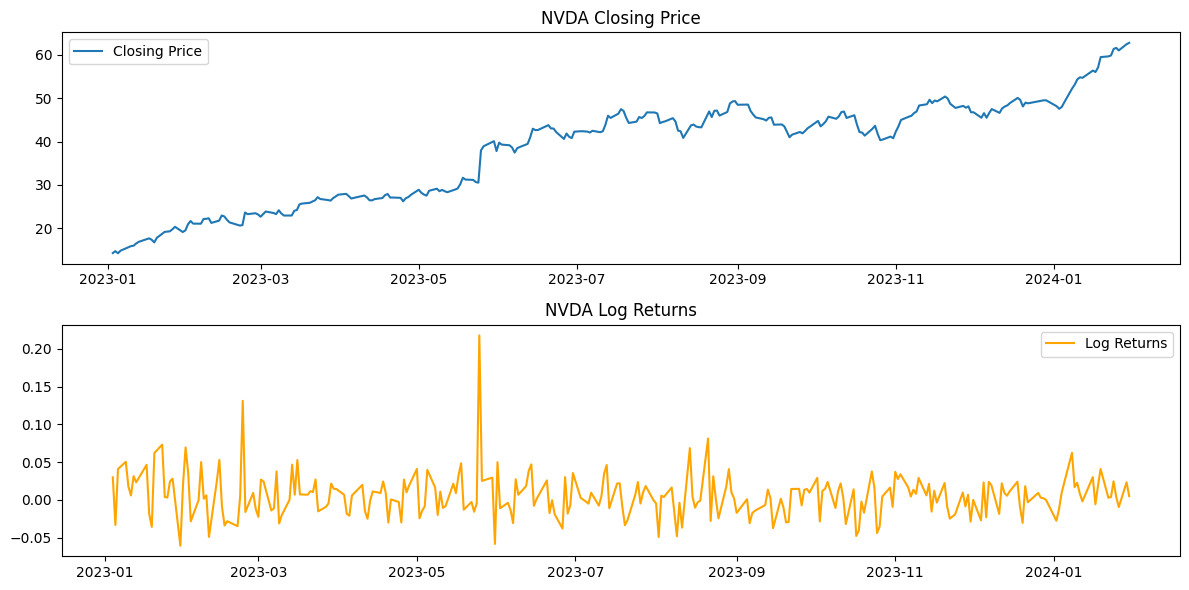

In [297]:
# Apply log transformation to the adjusted close price
stock['Log Price'] = np.log(stock['Adj Close'])

# Calculate log returns as the difference of log prices
stock['Log Returns'] = stock['Log Price'].diff()

# Check if 'Log Returns' is created successfully
# print(stock.head())  # Display the first few rows to verify

# Extract the log returns as a numpy array and calculate the length
log_Y = stock['Log Returns'].dropna().values  # Drop any NaN values before use
Y = stock['Adj Close'].dropna().values
log_S = len(log_Y)  # Length of log returns after dropping NaN values
S = len(Y)  # Length of time series after dropping NaN values

# Plot the closing prices and log returns for visual inspection
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.plot(stock['Adj Close'], label='Closing Price')
plt.title(f'{stock_symbol} Closing Price')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(stock['Log Returns'], label='Log Returns', color='orange')
plt.title(f'{stock_symbol} Log Returns')
plt.legend()
plt.tight_layout()
plt.show()


In [298]:
# Perform ADF (Augmented Dickey-Fuller) Test to check for stationarity
adf_result = adfuller(log_Y)
print("ADF Test Statistic:", adf_result[0])
print("p-value:", adf_result[1])
for key, value in adf_result[4].items():
    print(f"Critical Value {key}: {value}")
if adf_result[1] < 0.05:
    print("The series is stationary based on the ADF test (p < 0.05).")
else:
    print("The series is non-stationary based on the ADF test (p >= 0.05).")


ADF Test Statistic: -10.650555539843884
p-value: 4.673226151062826e-19
Critical Value 1%: -3.455175292841607
Critical Value 5%: -2.8724677563219485
Critical Value 10%: -2.57259315846006
The series is stationary based on the ADF test (p < 0.05).


In [299]:
# Perform KPSS (Kwiatkowski-Phillips-Schmidt-Shin) Test to check for stationarity
kpss_result = kpss(log_Y, regression='c')
print("KPSS Test Statistic:", kpss_result[0])
print("p-value:", kpss_result[1])
for key, value in kpss_result[3].items():
    print(f"Critical Value {key}: {value}")
if kpss_result[1] > 0.05:
    print("The series is stationary based on the KPSS test (p > 0.05).")
else:
    print("The series is non-stationary based on the KPSS test (p <= 0.05).")


KPSS Test Statistic: 0.3091322360076874
p-value: 0.1
Critical Value 10%: 0.347
Critical Value 5%: 0.463
Critical Value 2.5%: 0.574
Critical Value 1%: 0.739
The series is stationary based on the KPSS test (p > 0.05).


C:\Users\56111\AppData\Local\Temp\ipykernel_15060\1937717665.py:2: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_result = kpss(log_Y, regression='c')


In [300]:
def garch(garch_params, *args):
    mu = garch_params[0]
    omega = garch_params[1]
    alpha = garch_params[2]
    beta = garch_params[3]
    mu1 = garch_params[4]
    sig1 = garch_params[5]
    mu2 = garch_params[6]
    sig2 = garch_params[7]
    p = garch_params[8]
    sigma2, F1, F2, v = {}, {}, {}, {}
    GARCH_dens1, GARCH_dens2, GARCH_dens_mix = {}, {}, {}
    sigma2[0] = np.var(log_Y)
    Likelihood = 0
    for t in range(1, log_S):
        sigma2[t] = omega + alpha * ((log_Y[t-1] - mu) ** 2) + beta * sigma2[t-1]
        if sigma2[t] < 0:
            sigma2[t] = 1e-2
        mixture_shocks1 = np.random.normal(mu1, sig1, 1)
        mixture_shocks2 = np.random.normal(mu2, sig2, 1)
        F1[t] = log_Y[t] - mu - np.sqrt(sigma2[t]) * mixture_shocks1
        F2[t] = log_Y[t] - mu - np.sqrt(sigma2[t]) * mixture_shocks2
        v[t] = sigma2[t]
        GARCH_dens1[t] = (1/2) * np.log(2 * np.pi) + (1/2) * np.log(v[t]) + (1/2) * (F1[t] / v[t])
        GARCH_dens2[t] = (1/2) * np.log(2 * np.pi) + (1/2) * np.log(v[t]) + (1/2) * (F2[t] / v[t])
        u = np.random.uniform(0, 1, 1)
        GARCH_dens_mix[t] = (u <= p) * GARCH_dens1[t] + (u > p) * GARCH_dens2[t]
        Likelihood += GARCH_dens_mix[t]

    return Likelihood


In [301]:
def garch_path(garch_params, *args):
    mu = garch_params[0]
    omega = garch_params[1]
    alpha = garch_params[2]
    beta = garch_params[3]
    mu1 = garch_params[4]
    sig1 = garch_params[5]
    mu2 = garch_params[6]
    sig2 = garch_params[7]
    p = garch_params[8]
    sigma2, path = {}, {}
    sigma2[0] = np.var(log_Y)
    path[0] = np.array([log_Y[0]])
    for t in range(1, log_S):
        sigma2[t] = omega + alpha * ((log_Y[t-1] - mu) ** 2) + beta * sigma2[t-1]
        if sigma2[t] < 0:
            sigma2[t] = 1e-2
        mixture_shocks1 = np.random.normal(mu1, sig1, 1)
        mixture_shocks2 = np.random.normal(mu2, sig2, 1)
        u = np.random.uniform(0, 1, 1)
        mixture_shocks = (u <= p) * mixture_shocks1 + (u > p) * mixture_shocks2
        path[t] = mu + np.sqrt(sigma2[t]) * mixture_shocks

    return path, sigma2


In [302]:
# Initial parameter guess
garch_param0 = np.array([np.mean(log_Y), np.var(log_Y) / 1600, 0.06, 0.78, 0.04, 0.82, 0.002, 0.92, 0.02])

# Optimize parameters using maximum likelihood estimation
garch_results = minimize(garch, garch_param0, method='BFGS', tol=1e-10, options={'disp': True})
garch_param_star = garch_results.x  # Optimized parameters


         Current function value: -2916.354790
         Iterations: 1
         Function evaluations: 279
         Gradient evaluations: 27


RMSE value is: 3.272694364799203%


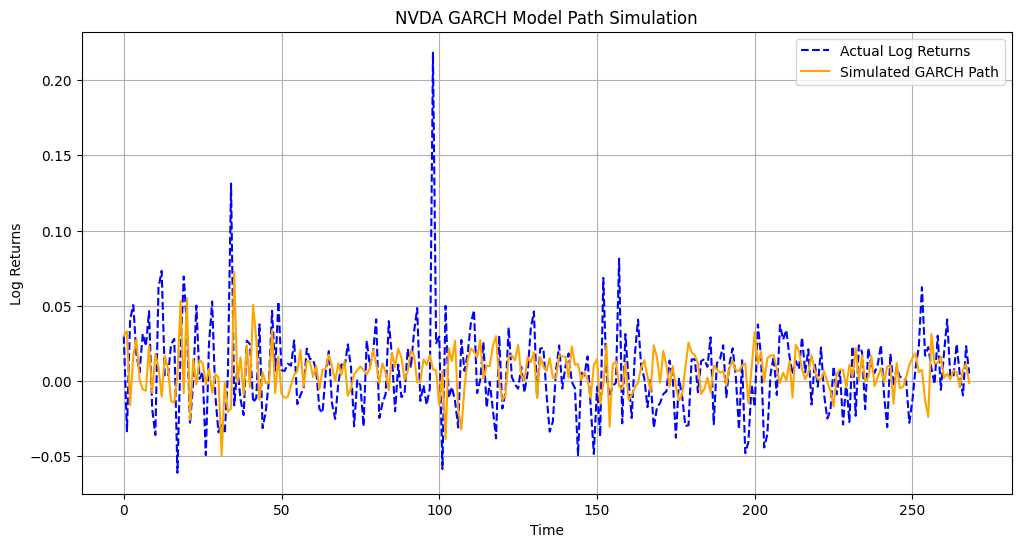

In [303]:
# Simulate the GARCH path using the optimized parameters
simulated_garch_path, garch_variance_path = garch_path(garch_param_star)

# Extract the simulated GARCH path for plotting and RMSE calculation
log_Y_GARCH = [simulated_garch_path[t][0] for t in range(log_S)]
GARCH_prediction = list(log_Y_GARCH)

# Calculate RMSE
RMSE = np.sqrt(np.mean((np.array(GARCH_prediction) - np.array(log_Y))**2))
print(f'RMSE value is: {RMSE*100}%')

# Visualization of GARCH path
plt.figure(figsize=(12, 6))
plt.plot(log_Y, label='Actual Log Returns', color='blue', linestyle='--')
plt.plot(list(simulated_garch_path.values()), label='Simulated GARCH Path', color='orange')
plt.title(f'{stock_symbol} GARCH Model Path Simulation')
plt.xlabel('Time')
plt.ylabel('Log Returns')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()


In [304]:
def kalman_filter(param,*args):
    # initialize params
    Z = param[0]
    T = param[1]
    H = param[2]
    Q = param[3]
    # initialize vector values:
    u_predict,  u_update,  P_predict, P_update, v, F = {},{},{},{},{},{}
    u_update[0] = Y[0]
    u_predict[0] = u_update[0] 
    P_update[0] = np.var(Y)/4 
    P_predict[0] =  T*P_update[0]*np.transpose(T)+Q  
    Likelihood = 0
    for s in range(1, S):
        F[s] = Z*P_predict[s-1]*np.transpose(Z)+H 
        v[s]= Y[s-1]-Z*u_predict[s-1]   
        u_update[s] = u_predict[s-1]+P_predict[s-1]*np.transpose(Z)*(1/F[s])*v[s]
        u_predict[s] = T*u_update[s]
        P_update[s] = P_predict[s-1]-P_predict[s-1]*np.transpose(Z)*(1/F[s])*Z*P_predict[s-1]
        P_predict[s] = T*P_update[s]*np.transpose(T)+Q
        Likelihood += (1/2)*np.log(2*np.pi)+(1/2)*np.log(abs(F[s]))+(1/2)*np.transpose(v[s])*(1/F[s])*v[s]      
    
    return Likelihood

In [305]:
def kalman_smoother(params, *args):
    # initialize params
    Z = params[0]
    T = params[1]
    H = params[2]
    Q = params[3] 
    # initialize vector values:
    u_predict,  u_update,  P_predict, P_update, v, F = {},{},{},{},{},{}
    u_update[0] = Y[0]
    u_predict[0] = u_update[0] 
    P_update[0] = np.var(Y)/4 
    P_predict[0] =  T*P_update[0]*np.transpose(T)+Q  
    for s in range(1, S):
        F[s] = Z*P_predict[s-1]*np.transpose(Z)+H 
        v[s]=Y[s-1]-Z*u_predict[s-1]   
        u_update[s] = u_predict[s-1]+P_predict[s-1]*np.transpose(Z)*(1/F[s])*v[s]
        u_predict[s] = T*u_update[s]
        P_update[s] = P_predict[s-1]-P_predict[s-1]*np.transpose(Z)*(1/F[s])*Z*P_predict[s-1]
        P_predict[s] = T*P_update[s]*np.transpose(T)+Q
    
    u_smooth, P_smooth = {}, {}
    u_smooth[S-1] = u_update[S-1]
    P_smooth[S-1] = P_update[S-1]    
    for t in range(S-1, 0, -1):
        u_smooth[t-1] = u_update[t] + P_update[t]*np.transpose(T)/P_predict[t]*(u_smooth[t]-T*u_update[s])
        P_smooth[t-1] = P_update[t] + P_update[t]*np.transpose(T)/P_predict[t]*(P_smooth[t]-P_predict[t])/P_predict[t]*T*P_update[t]
    
    # del u_update[-1]
    smooth_path = u_smooth
    return smooth_path 

In [306]:
# Minimize Kalman filter likelihood function
kalman_param0 = np.array([1.05, 0.96, np.var(Y)/200, np.var(Y)/100])
kalman_results = minimize(kalman_filter, kalman_param0, method='BFGS', tol=1e-2, options={'disp': True})


Optimization terminated successfully.
         Current function value: 390.899216
         Iterations: 19
         Function evaluations: 140
         Gradient evaluations: 28


In [307]:
# Smooth and visualize the estimated path
kalman_param_star = kalman_results.x
path = kalman_smoother(kalman_param_star, Y, S)
sorted_path = dict(sorted(path.items()))
Y_kalmanFilter = sorted_path.values()

RMSE values is: $ 6.5803835684110545


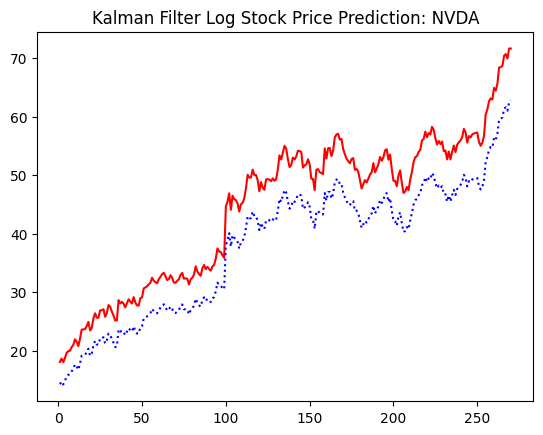

In [308]:
# Time vector for plotting
timevec = np.linspace(1,S,S)
plt.title('Kalman Filter Log Stock Price Prediction: '+ stock_symbol)
plt.plot(timevec, Y_kalmanFilter,'r',timevec, Y,'b:')

# Extracting the dictionary values into a list (in the same order as keys)
kalman_values = list(Y_kalmanFilter)

# Calculate RMSE
RMSE = np.sqrt(np.mean((np.array(kalman_values) - np.array(Y))**2))
print('RMSE values is: $', RMSE)

In [309]:
# Use the Kalman filter's smoothed values as the midprice
midprice_kalman = np.array(list(Y_kalmanFilter))  # Convert to array if necessary

# Step 1: Calculate GARCH-based spread using the standard deviation of GARCH volatility on log scale
garch_variance_values = np.array(list(garch_variance_path.values()))  # Extract GARCH variance values from dictionary
garch_volatility_log = np.sqrt(garch_variance_values)  # Standard deviation (volatility) from GARCH variance
spread_log = garch_volatility_log[:269]  # Spread is based on log-return volatility

# Step 2: Apply log transformation to Kalman filter midprice to match log scale
log_midprice_kalman = np.log(midprice_kalman)[:269]

# Define the upper and lower bounds on log scale
upper_bound_log = log_midprice_kalman + spread_log
lower_bound_log = log_midprice_kalman - spread_log

# Convert log-scale bounds back to original scale for interpretation
midprice_original = np.exp(log_midprice_kalman)
upper_bound_original = np.exp(upper_bound_log)
lower_bound_original = np.exp(lower_bound_log)

In [311]:
print('The log-scale spread is:', spread_log[:10])

The log-scale spread is: [0.02886165 0.02618964 0.02502291 0.02374204 0.02369583 0.02115662
 0.01869921 0.01770434 0.01624421 0.01751704]


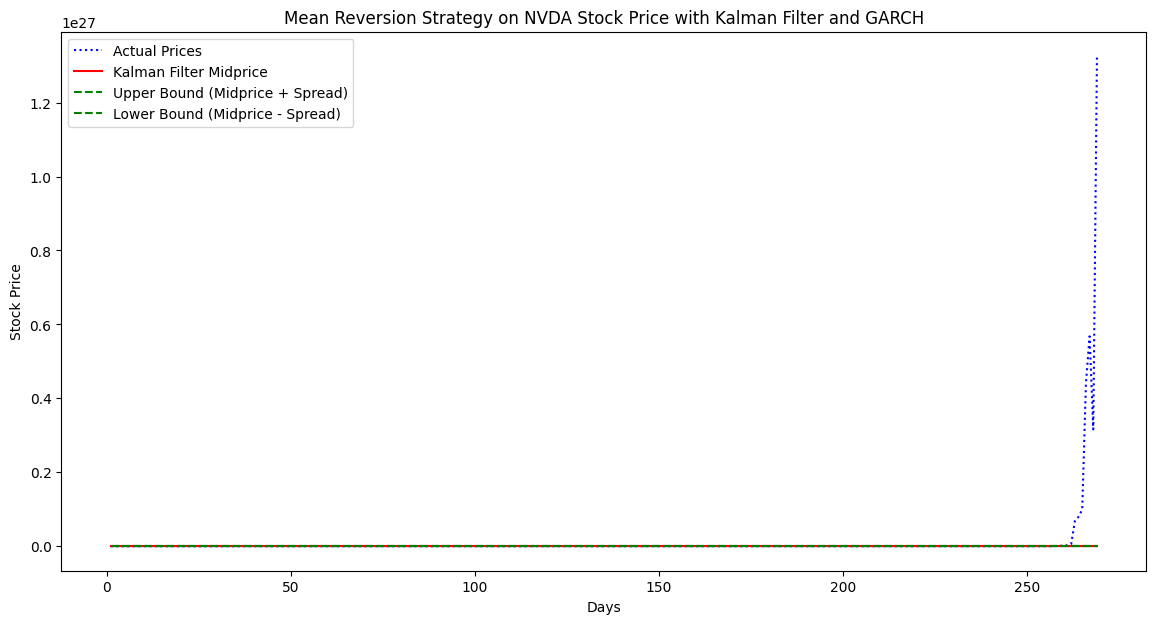

In [315]:
# Plot Mean Reversion Strategy with original stock prices
timevec = np.linspace(1, S, S)[:269]
plt.figure(figsize=(14, 7))
plt.plot(timevec, np.exp(Y)[:269], 'b:', label='Actual Prices')  # Convert Y to original scale for plotting
plt.plot(timevec, midprice_original[:269], 'r', label='Kalman Filter Midprice')
plt.plot(timevec, upper_bound_original[:269], 'g--', label='Upper Bound (Midprice + Spread)')
plt.plot(timevec, lower_bound_original[:269], 'g--', label='Lower Bound (Midprice - Spread)')
plt.fill_between(timevec, lower_bound_original[:269], upper_bound_original[:269], color='gray', alpha=0.3)
plt.xlabel('Days')
plt.ylabel('Stock Price')
plt.title('Mean Reversion Strategy on NVDA Stock Price with Kalman Filter and GARCH')
plt.legend()
plt.show()

In [ ]:
# Implement mean-reversion trading signal based on bounds in original scale
def generate_mean_reversion_signal(price, midprice, upper_bound, lower_bound):
    # Signal: -1 for short when above upper bound, 1 for long when below lower bound, 0 for neutral
    signal = np.where(price > upper_bound, -1, np.where(price < lower_bound, 1, 0))
    return signal

# Generate signals on original price scale
original_price = np.exp(Y)  # Convert log returns back to original price scale
signals = generate_mean_reversion_signal(original_price[:269], midprice_original[:269], upper_bound_original[:269], lower_bound_original[:269])

# Plot the signals along with actual stock prices
plt.figure(figsize=(14, 7))
plt.plot(timevec, signals, label='Mean Reversion Signal', color='orange', alpha=0.7)
plt.xlabel('Days')
plt.ylabel('Signal')
plt.title('Mean Reversion Signals for NVDA Stock')
plt.legend()
plt.show()

ValueError: operands could not be broadcast together with shapes (270,) (269,) 